# Classifying thyroid cancer from numerical data

## Abstract

This notebook demonstrates a simple machine learning pipeline used to diagnose Thyroid cancer from numerical data. The dataset was sourced from kaggle, and we apply a binary classifier neural network to the dataset to predict whether a diagnosis was benign or malignant. We see the produced model is prone to predicting false negatives which could be a major concern in a medical setting, and so further work is needed to refine this.

## Learning Outcomes

By following this notebook, the reader should be able to:
- Import a dataset from kaggle using the kagglehub library and the pandas adapter
- Validate data integrity
- Preprocess data (encode and normalise)
- Visualise relations between features and classes
- Define and train a neural network for binary classification
- Experiment with adjusting hyper-parameters
- Visualise results and efficacy of trained models

What this notebook does not focus on is:
- Optimising model performance. For these areas, I recommend reviewing [5] for an overview of optimising classifiers for higher accuracy
- In depth data preprocessing. For reference on how to do this, I recommend Miami University's Data Cleaning Tutorial [6].
- Comparison of encoding methods on model performance. For an overview of encoding methods, I recommend [7]

## Table of Contents

1. Abstract
2. Learning Outcomes
3. Methodology

## Methodology

This section covers the entire implementation of classification, from downloading the dataset to evaluating our trained model's performance on a subset of the data. However, before getting started, there are a few steps we must first complete. Some of the code snippets taken from kaggle require the pandas adaptor for kagglehub which isn't available via conda. The following cell simply installs this:

In [ ]:
! pip install "kagglehub[pandas-datasets]"

Next, we define the device that torch will use to train our model later. If you have access to an NVIDIA GPU, you can swap this to CUDA for *possibly* faster training (note: this isn't what I personally experienced, and the CPU is adequately fast enough as the model is very small, however this information should be kept in mind if adjusting to a larger model and training time becomes too large)

In [1]:
import torch

# Code from [4]
device = "cpu"
print(f"Using {device} device")
torch.set_default_device(device)
# End of source [4]

Using cpu device


We now load "Thyroid Cancer Risk" dataset from kaggle using kagglehub and the kagglehub pandas adaptor and save it to the variable ```df```. The dataset includes a Patient_ID column, which has no statistical significance with the record's class and simply acts as an identifier value. For this reason, its dropped from the dataset before continuing to the following stages. We then can see an overview of the data in the Pandas DataFrame:

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# dataset and code as from [1]
file_path = "thyroid_cancer_risk_data.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "bhargavchirumamilla/thyroid-cancer-risk-dataset",
  file_path,
)
# End of source [1]

# Remove unnecassary column
df = df.drop(columns="Patient_ID")
df


<ipython-input-2-941c74f83df9>:9: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 16.9M/16.9M [00:00<00:00, 134MB/s]


,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,58,Female,India,Asian,No,No,No,No,Yes,No,2.00,0.64,11.92,1.48,Low,Benign
212687,89,Male,Japan,Middle Eastern,No,No,No,No,Yes,No,9.77,3.25,7.30,4.46,Medium,Benign
212688,72,Female,Nigeria,Hispanic,No,No,No,No,No,Yes,7.72,2.44,8.71,2.36,Medium,Benign
212689,85,Female,Brazil,Middle Eastern,No,No,No,No,No,Yes,5.62,2.53,9.62,1.54,Medium,Benign


We must next ensure that there are no missing values in our dataset. In order to do this, we use DataFrame.isnull() and sum these values using numpy.sum(). As you can see, this dataset is somewhat unrealistic and does not have any missing values.

In [3]:
import numpy as np

np.sum(df.isnull())

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
Age,0
Gender,0
Country,0
Ethnicity,0
Family_History,0
Radiation_Exposure,0
Iodine_Deficiency,0
Smoking,0
Obesity,0
Diabetes,0


The dataset includes the following categorical data columns: "Gender", "Country", "Ethnicity", "Family_History", "Radiation_Exposure", "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk", "Diagnosis". In order to use these in a neural network, we must encode these values. For simplicity sake, and keeping the dimensionality of the dataset low, these columns are all encoded using Sci-kit Learn's Label encoder. The process and the output can be seen below:

In [4]:
from sklearn.preprocessing import LabelEncoder

#Encode data
le = LabelEncoder()
encoded_df = df.copy()

columns = ["Gender", "Country", "Ethnicity", "Family_History", "Radiation_Exposure", "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk", "Diagnosis"]

for column in columns:
  encoded_df[column] = le.fit_transform(df[column])

encoded_df

,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,1,6,2,0,1,0,0,0,0,9.37,1.67,6.16,1.08,1,0
1,29,1,2,3,0,1,0,0,0,0,1.83,1.73,10.54,4.05,1,0
2,86,1,5,2,0,0,0,0,0,0,6.26,2.59,10.57,4.61,1,0
3,75,0,3,1,0,0,0,0,0,0,4.10,2.62,11.04,2.46,2,0
4,35,0,2,0,1,1,0,0,0,0,9.10,2.11,10.71,2.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,58,0,3,1,0,0,0,0,1,0,2.00,0.64,11.92,1.48,1,0
212687,89,1,4,4,0,0,0,0,1,0,9.77,3.25,7.30,4.46,2,0
212688,72,0,5,3,0,0,0,0,0,1,7.72,2.44,8.71,2.36,2,0
212689,85,0,0,4,0,0,0,0,0,1,5.62,2.53,9.62,1.54,2,0


Not all features are equal and so, in order to visual their relationship with the label, we group cancer risk levels against diagnosis and perform a Chi squared test on all features.

<ipython-input-5-a9e228ced0ce>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['Thyroid_Cancer_Risk', 'Diagnosis']).size().unstack()


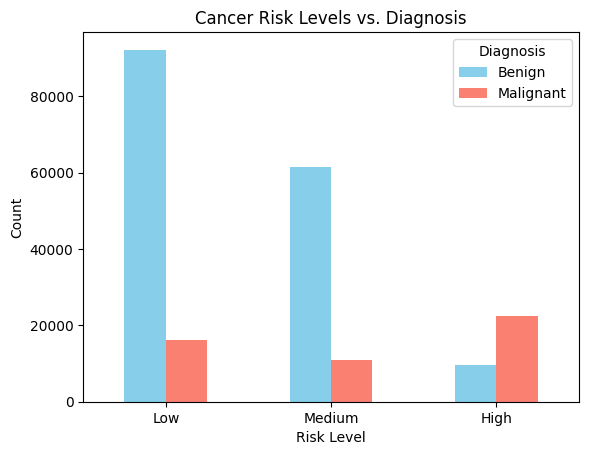

In [5]:
df['Thyroid_Cancer_Risk'] = pd.Categorical(df['Thyroid_Cancer_Risk'], categories=['Low', 'Medium', 'High'], ordered=True)
counts = df.groupby(['Thyroid_Cancer_Risk', 'Diagnosis']).size().unstack()
counts.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.title('Cancer Risk Levels vs. Diagnosis')
plt.xticks(rotation=0)
plt.legend(title='Diagnosis')

                Feature    Chi2 Stat       P-value
14  Thyroid_Cancer_Risk  9608.660813  0.000000e+00
4        Family_History  2956.299276  0.000000e+00
3             Ethnicity  1990.222073  0.000000e+00
6     Iodine_Deficiency  1565.973944  0.000000e+00
5    Radiation_Exposure  1433.738538  0.000000e+00
2               Country   161.814823  4.540931e-37
10            TSH_Level     2.458406  1.168974e-01
9              Diabetes     1.761771  1.844038e-01
13          Nodule_Size     1.252263  2.631206e-01
11             T3_Level     0.454651  5.001344e-01
1                Gender     0.264209  6.072430e-01
8               Obesity     0.226356  6.342394e-01
12             T4_Level     0.178488  6.726762e-01
7               Smoking     0.126405  7.221894e-01
0                   Age     0.025448  8.732552e-01


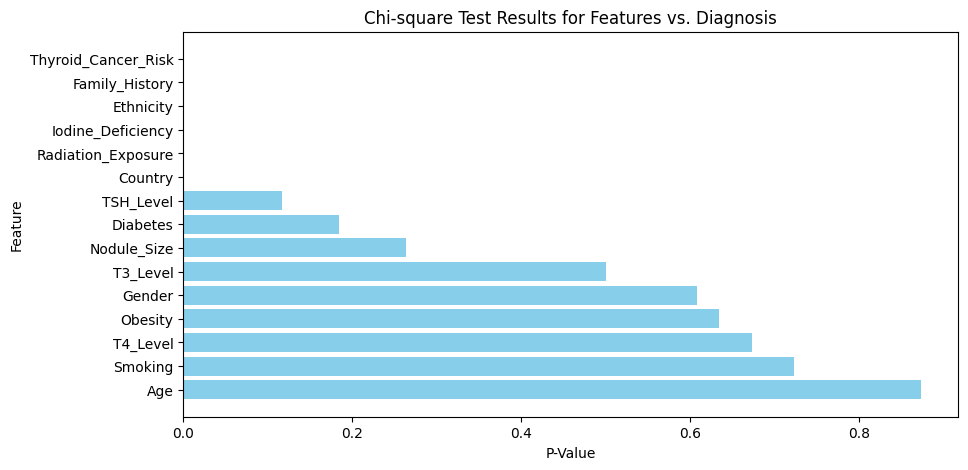

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2

# Code from [8]
X = encoded_df.drop(columns=['Diagnosis'])
y = encoded_df['Diagnosis']
chi2_stats, p_values = chi2(X, y)
# End of sourcec [8]

chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2 Stat': chi2_stats, 'P-value': p_values})
chi2_df = chi2_df.sort_values(by='Chi2 Stat', ascending=False)

print(chi2_df)

# Plot results
plt.figure(figsize=(10, 5))
plt.barh(chi2_df['Feature'], chi2_df['P-value'], color='skyblue')
plt.xlabel("P-Value")
plt.ylabel("Feature")
plt.title("Chi-square Test Results for Features vs. Diagnosis")
plt.gca().invert_yaxis()
plt.show()


As you can see, the factors with the highest correlations to diagnosis type (in order) are:
- Thyroid Cancer Risk
- Family History
- Ethnicity
- Idodine-Deficiency
- Radiation_Exposure
- Country

We can argue, with a certain level of confidence, that factors such as nodule_size, gender, obesity and age have no statistical relevance on whether a thyroid cancer diagnosis is benign or malignant.

Next, we split the data in to features and labels, normalise the features, and then split both the features and labels into training and testing sets, stratifying the split over the label classes

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize the DataFrame
normalised_df = pd.DataFrame(scaler.fit_transform(encoded_df), columns=encoded_df.columns)

features = encoded_df.drop(columns=["Diagnosis"])
normalised_features = scaler.fit_transform(features)
labels = encoded_df["Diagnosis"].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(normalised_features, labels, stratify=labels, test_size=0.2)


x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test.shape

torch.Size([42539, 15])

Next, we train 3 binary classifier neural network on the training data. Each one has a slightly different configuration of hyperparameters to see how these effect the performance of the network.
1. The first network uses 1 hidden layer with a signmoid function to output the probability of a class. It uses the Adam optimiser with a learning rate of 0.01 and weight decay of 0.001
2. The second network consists of 2 hidden layers and uses the ReLU activation function and the sigmoid function. This is to see the effect of changing the hidden layer structure when compared with the first model. For consistency, it uses the same optimiser as model 1
3. The third network consists of the same 2 hidden layers as model 2, but uses a different optimiser - the SGD - to observe how this affects the models performance
4. The final network consists of the same 2 hidden layers, but ups the momentum of the SGD to observe its effect on the performance


In [72]:
#Code from [2]
class NeuralNetwork(torch.nn.Module):
  def __init__(self, name, layers, criterion, optimizer_class, optimizer_kwargs):
    super().__init__()
    self.name = name
    self.flatten = torch.nn.Flatten()
    self.connected_layers = layers
    self.criterion = criterion
    self.optimizer = optimizer_class(self.parameters(), **optimizer_kwargs)
    self.losses = []
    self.accuracies = []


  def forward(self, x):
    x = self.flatten(x)
    output = self.connected_layers(x)
    return output

  def backward(self, y_pred):
    self.optimizer.zero_grad()
    loss = self.criterion(y_pred.squeeze(), y_train)
    self.losses.append(loss.item())
    # Start of source [9]
    accuracy = (y_pred.squeeze().round() == y_train).float().mean()
    self.accuracies.append(accuracy.item())
    # End of source [9]
    loss.backward()
    self.optimizer.step()
    return loss

  def train(self, x, y, epochs):
    print(f"Training {self.name}")
    for epoch in range(0, epochs):
      y_pred = self.forward(x)
      loss = self.backward(y_pred)
      if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"epoch = {epoch}, loss = {loss}")
    print(f"Done training {self.name}\n")
#End of source [2]

In [77]:
INPUT_SIZE = x_train.shape[1]

networks = [
    NeuralNetwork(
        name="Model 1",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.Adam,
        optimizer_kwargs = {"lr": 0.01, "weight_decay":0.001}
      ),
    NeuralNetwork(
        name="Model 2",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.Adam,
        optimizer_kwargs = {"lr": 0.01, "weight_decay":0.001}
      ),
    NeuralNetwork(
        name="Model 3",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.SGD,
        optimizer_kwargs = {"lr": 0.01, "momentum": 0.5, "weight_decay":0.001}
      ),
    NeuralNetwork(
        name="Model 4",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.SGD,
        optimizer_kwargs = {"lr": 0.01, "momentum": 1, "weight_decay":0.001}
      ),
    ]

Training Model 1
epoch = 0, loss = 0.6884027123451233
epoch = 10, loss = 0.5791500210762024
epoch = 20, loss = 0.5543803572654724
epoch = 30, loss = 0.5480791330337524
epoch = 40, loss = 0.5390685796737671
epoch = 50, loss = 0.5316123962402344
epoch = 60, loss = 0.5261863470077515
epoch = 70, loss = 0.5213723182678223
epoch = 80, loss = 0.5173423886299133
epoch = 90, loss = 0.5139574408531189
epoch = 99, loss = 0.5113216638565063
Done training Model 1

Training Model 2
epoch = 0, loss = 0.842640221118927
epoch = 10, loss = 0.7305830717086792
epoch = 20, loss = 0.656333863735199
epoch = 30, loss = 0.5760767459869385
epoch = 40, loss = 0.5426974296569824
epoch = 50, loss = 0.5408682227134705
epoch = 60, loss = 0.5330536961555481
epoch = 70, loss = 0.5278461575508118
epoch = 80, loss = 0.5232637524604797
epoch = 90, loss = 0.5183644890785217
epoch = 99, loss = 0.5141527652740479
Done training Model 2

Training Model 3
epoch = 0, loss = 0.6178863048553467
epoch = 10, loss = 0.6109046936035

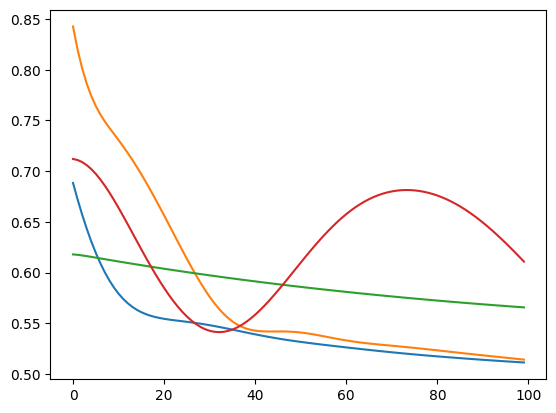

In [81]:


# Train networks and collect training data
for network in networks:
    network.train(x_train, y_train, 100)

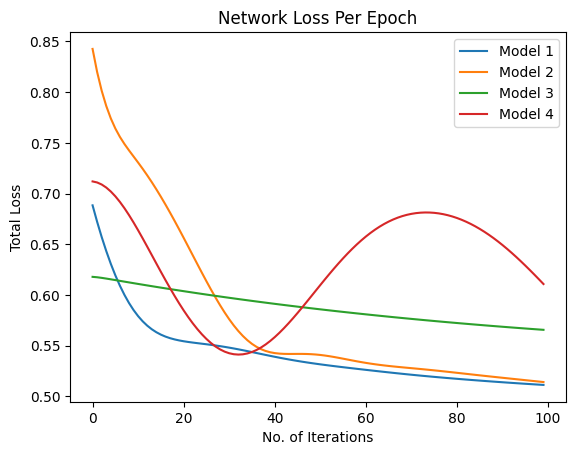

In [82]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

for network in networks:
    plt.plot(network.losses, label=network.name)

plt.title("Network Loss Per Epoch")
plt.xlabel("No. of Iterations")
plt.ylabel("Total Loss")
plt.legend()
plt.show()

Finally, we predict our labels on the test set, and visualise them in a confusion matrix.

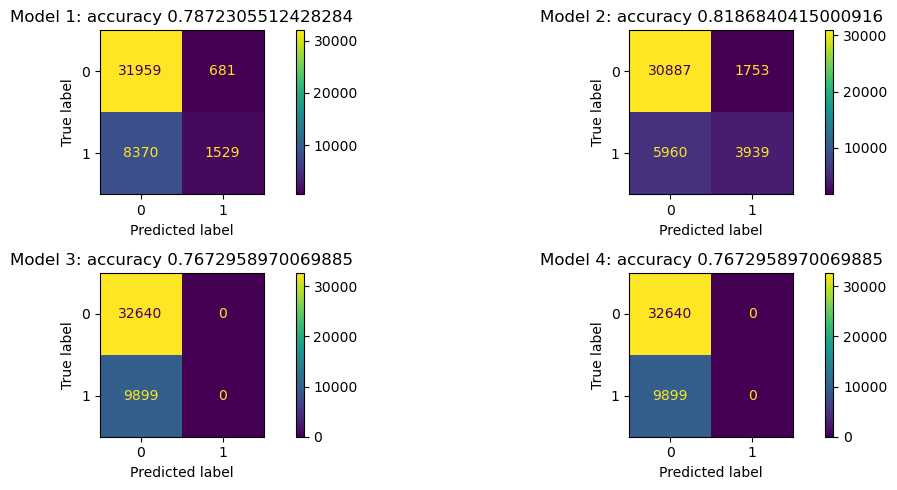

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with torch.no_grad():
    y_pred_1 = model_1(x_test)
    predicted_labels_1 = (y_pred_1 >= 0.5).float()
    accuracy_1 = (predicted_labels_1.squeeze() == y_test).float().mean()
    cm_1 = confusion_matrix(y_test, predicted_labels_1)

    y_pred_2 = model_2(x_test)
    predicted_labels_2 = (y_pred_2 >= 0.5).float()
    accuracy_2 = (predicted_labels_2.squeeze() == y_test).float().mean()
    cm_2 = confusion_matrix(y_test, predicted_labels_2)

    y_pred_3 = model_3(x_test)
    predicted_labels_3 = (y_pred_3 >= 0.5).float()
    accuracy_3 = (predicted_labels_3.squeeze() == y_test).float().mean()
    cm_3 = confusion_matrix(y_test, predicted_labels_3)

    y_pred_4 = model_4(x_test)
    predicted_labels_4 = (y_pred_4 >= 0.5).float()
    accuracy_4 = (predicted_labels_4.squeeze() == y_test).float().mean()
    cm_4 = confusion_matrix(y_test, predicted_labels_4)


# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Display confusion matrices
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1)
disp_1.plot(ax=axes[0][0])
axes[0][0].set_title(f"Model 1: accuracy {accuracy_1.item()}")

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp_2.plot(ax=axes[0][1])
axes[0][1].set_title(f"Model 2: accuracy {accuracy_2.item()}")

disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3)
disp_3.plot(ax=axes[1][0])
axes[1][0].set_title(f"Model 3: accuracy {accuracy_3.item()}")

disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4)
disp_4.plot(ax=axes[1][1])
axes[1][1].set_title(f"Model 4: accuracy {accuracy_4.item()}")


plt.tight_layout()
plt.show()
# End of [3]

# References
1. https://www.kaggle.com/datasets/bhargavchirumamilla/thyroid-cancer-risk-dataset
2. https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
3. https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-model
4. https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
5. https://medium.com/foundational-data-science-interview-questions/five-tips-to-improve-your-binary-classification-modeling-d1568396063f
6. https://miamioh.edu/centers-institutes/center-for-analytics-data-science/students/coding-tutorials/python/data-cleaning.html
7. https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b
8. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
9. https://github.com/Prixis10/Breast-Cancer-Detection-Using-Pytorch/blob/main/breast_cancer_detection.ipynb